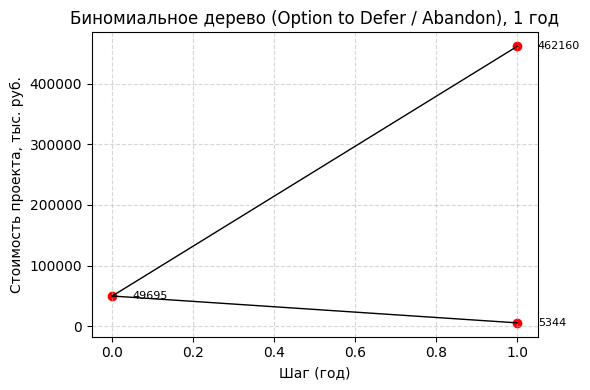

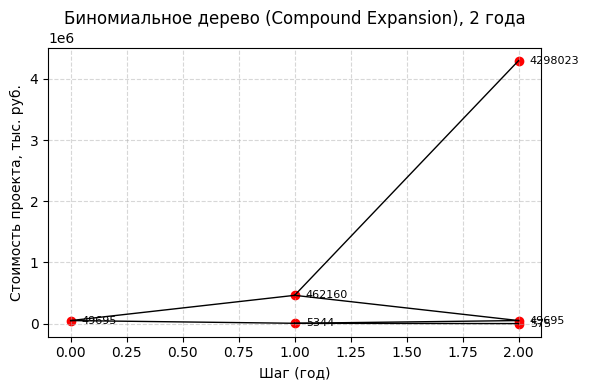

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def build_and_plot_tree(S0, sigma, r, n_steps, title):
    """
    Строит и рисует биномиальное дерево для базового актива.
    - S0: начальная стоимость актива (PV сейчас), тыс. руб.
    - sigma: волатильность (в долях, т.е. 2.23 для 223%)
    - r: безрисковая ставка (0.21 для 21%)
    - n_steps: число шагов (лет)
    - title: заголовок графика
    """

    # Расчет коэффициентов u, d и риск-нейтральной вероятности p
    dt = 1  # шаг = 1 год
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Подготовка координат для узлов
    # узел (i, j): i = уровень (0..n_steps), j = число "вверх" (0..i)
    nodes = []  # список кортежей (i, j, значение)
    for i in range(n_steps + 1):
        for j in range(i + 1):
            # j — количество "вверх" движений, i-j — "вниз"
            value = S0 * (u ** j) * (d ** (i - j))
            nodes.append((i, j, value))

    # Рисуем дерево
    plt.figure(figsize=(6, 4))
    # Соединяем родительские узлы с потомками
    for i, j, value in nodes:
        if i < n_steps:
            # левый потомок: (i+1, j) — движение вниз
            x0, y0 = i, value
            x_left, y_left = i + 1, S0 * (u ** j) * (d ** ((i + 1) - j))
            plt.plot([x0, x_left], [y0, y_left], 'k-', linewidth=1)
            # правый потомок: (i+1, j+1) — движение вверх
            x_right, y_right = i + 1, S0 * (u ** (j + 1)) * (d ** (i - j))
            plt.plot([x0, x_right], [y0, y_right], 'k-', linewidth=1)

    # Рисуем узлы и подписи
    for i, j, value in nodes:
        x, y = i, value
        plt.scatter(x, y, color='red')
        plt.text(x + 0.05, y, f"{value:.0f}", fontsize=8, va='center')

    plt.title(title)
    plt.xlabel("Шаг (год)")
    plt.ylabel("Стоимость проекта, тыс. руб.")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Заданные пользователем данные
investment_cost = 15020  # тыс. руб.
PV_year1 = 61308        # тыс. руб.
PV_year2 = 115543       # тыс. руб.
PV_year3 = 151512       # тыс. руб.
sigma = 2.23             # волатильность = 223%
r = 0.21                 # безрисковая ставка = 21%
salvage = 660            # ликвидационная стоимость, тыс. руб.

# Вычисление S0 из PV_year1: дисконт обратно на 1 год по r
S0 = PV_year1 * np.exp(-r * 1)

# 1) Опцион на отсрочку (1 год) и опцион на прекращение (1 год)
build_and_plot_tree(S0, sigma, r, n_steps=1, title="Биномиальное дерево (Option to Defer / Abandon), 1 год")

# 2) Стратегия двух вложенных опционов на расширение (2 года)
build_and_plot_tree(S0, sigma, r, n_steps=2, title="Биномиальное дерево (Compound Expansion), 2 года")


In [2]:
import numpy as np

# Параметры проекта
investment_cost = 15020  # X: инвестиционные затраты для старта/отсрочки, тыс. руб.
PV_year1 = 61308         # PV через год 1 (справочная величина)
sigma = 2.23             # волатильность = 223%
r = 0.21                 # безрисковая ставка = 21%
salvage = 660            # ликвидационная стоимость для опциона на прекращение, тыс. руб.

# Вычисляем начальную стоимость S0 (PV сегодня) путём дисконтирования PV_year1
S0 = PV_year1 * np.exp(-r * 1)

# Параметры биномиального дерева
dt = 1                             # шаг = 1 год
u = np.exp(sigma * np.sqrt(dt))   # коэффициент «up»
d = 1 / u                          # коэффициент «down»
p = (np.exp(r * dt) - d) / (u - d) # риск-нейтральная вероятность
disc = np.exp(-r * dt)             # дисконт-фактор

# 1) Опцион на отсрочку (call, 1 шаг)
#    Strike = investment_cost
S_up = S0 * u
S_down = S0 * d
C_up = max(S_up - investment_cost, 0)
C_down = max(S_down - investment_cost, 0)
option_defer = disc * (p * C_up + (1 - p) * C_down)

# 2) Опцион на прекращение (abandon, 1 шаг, пут с ликвидацией)
#    Если продолжаем: получаем S, если гасим: получаем salvage
A_up = max(S_up, salvage)
A_down = max(S_down, salvage)
option_abandon = disc * (p * A_up + (1 - p) * A_down)

# 3) Две вложенные опционы на расширение (compound expansion)
#    Здесь нужно задать затраты X1 (в конце 1-го года) и X2 (в конце 2-го года).
#    В качестве примера взяты произвольные X1 и X2. Поменяйте их на реальные:
X1 = 8000  # пример: затраты на первое расширение (в тыс. руб.)
X2 = 6000  # пример: затраты на второе расширение (в тыс. руб.)

#--- Шаг t = 2: строим узлы проекта в конце 2-го года ---
S_uu = S0 * u**2        # «up-up»
S_ud = S0 * u * d       # «up-down» (или «down-up») — равно S0
S_dd = S0 * d**2        # «down-down»

# Выплаты второго опциона (call) с strike = X2
Pay_uu = max(S_uu - X2, 0)
Pay_ud = max(S_ud - X2, 0)
Pay_dd = max(S_dd - X2, 0)

# Приводим стоимость второго опциона (t = 2) к моменту t = 1
C2_u = disc * (p * Pay_uu + (1 - p) * Pay_ud)  # если в узле «up» в t=1
C2_d = disc * (p * Pay_ud + (1 - p) * Pay_dd)  # если в узле «down» в t=1

#--- Шаг t = 1: узлы для S1 ---
S1_up   = S_up       # S0 * u
S1_down = S_down     # S0 * d

# Выплата первого опциона (call) с strike = X1 + капитализация C2
C1_up   = max(S1_up   - X1 + C2_u, 0)
C1_down = max(S1_down - X1 + C2_d, 0)

# Приводим стоимость первого опциона (с «вложенным») к моменту t = 0
option_compound = disc * (p * C1_up + (1 - p) * C1_down)

# Вывод результатов
import pandas as pd

df = pd.DataFrame({
    'Опцион': [
        'Отсрочка (Defer, 1 год)', 
        'Прекращение (Abandon, 1 год)', 
        'Составной (Compound Expansion, 2 года)'
    ],
    'Цена опциона (PV), тыс. руб.': [
        option_defer, 
        option_abandon, 
        option_compound
    ]
})

print(df)


                                   Опцион  Цена опциона (PV), тыс. руб.
0                 Отсрочка (Defer, 1 год)                  44402.911442
1            Прекращение (Abandon, 1 год)                  49695.298952
2  Составной (Compound Expansion, 2 года)                  91708.458901
